In [4]:
from functools import lru_cache
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

@lru_cache(maxsize=None)
def fetch_data_from_source(file):
    '''
    Files:
        f1sim-data-2022.parquet
        f1sim-data-2023.parquet

        f1sim-data-dictionary.xlsx

        f1sim-ref-left.csv
        f1sim-ref-line.csv
        f1sim-ref-right.csv
        f1sim-ref-turns.csv
    '''
    if file.split(".")[1] == "parquet":
        df = pd.read_parquet(f"https://data3001-racing.s3.ap-southeast-2.amazonaws.com/{file}")
    elif file.split(".")[1] == "csv":
        df = pd.read_csv(f"https://data3001-racing.s3.ap-southeast-2.amazonaws.com/{file}", index_col = 0)
    elif file.split(".")[1] == "xlsx":
        df = pd.read_excel(f"https://data3001-racing.s3.ap-southeast-2.amazonaws.com/{file}")
    return df

In [2]:
left = fetch_data_from_source('f1sim-ref-left.csv')
right = fetch_data_from_source('f1sim-ref-right.csv')
line = fetch_data_from_source('f1sim-ref-line.csv')
turns = fetch_data_from_source('f1sim-ref-turns.csv')

In [5]:
df = fetch_data_from_source('track_ratio.csv')
df["on_track"] = np.where(df["track_ratio_left"]+df["track_ratio_right"]<1.1, 1, 0)

df['agg'] = df['SESSION_IDENTIFIER'].astype(str) + '_' + df['LAP_NUM'].astype(str)
df

,LAP_INDEX,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ,left_shortest,right_shortest,left_closest,right_closest,left_closest_x,left_closest_y,right_closest_x,right_closest_y,track_width,track_ratio_left,track_ratio_right,on_track,agg
0,1,1.003468e+19,1680,1,1,1.775714,16,30129,18569,87226.0,38528.0,294.0,1.0,0.030945,8.0,10541.0,-0.018082,-2.336760,0.004231,-0.025839,113.192245,465.303589,2.900799,-23615.0,-138.0,-22714.0,22704.0,846.0,-23610.0,3.455802,10.174289,"(116.08881378173828, 467.1883850097656)","(105.4539566040039, 458.6979064941406)",116.088814,467.188385,105.453957,458.697906,13.608395,0.253946,0.747648,1,1.00346768666644e+19_1
1,1,1.003468e+19,1681,1,1,5.864580,66,30129,18569,87226.0,38528.0,294.0,1.0,0.030945,8.0,10547.0,-0.018174,-2.333671,0.005806,-0.025955,116.142723,462.470612,2.874730,-23685.0,-190.0,-22641.0,22630.0,850.0,-23681.0,3.365434,10.182519,"(118.38107299804688, 464.9837646484375)","(109.8089599609375, 454.4977111816406)",118.381073,464.983765,109.808960,454.497711,13.543945,0.248483,0.751813,1,1.00346768666644e+19_1
2,1,1.003468e+19,1682,1,1,9.964501,116,30129,18569,87226.0,38528.0,295.0,1.0,0.031952,8.0,10563.0,-0.013687,-2.330126,0.005979,-0.024798,119.108170,459.637115,2.845881,-23765.0,-195.0,-22557.0,22547.0,812.0,-23761.0,3.497007,10.153931,"(121.62169647216795, 462.06842041015625)","(112.1916275024414, 452.2031555175781)",121.621696,462.068420,112.191628,452.203156,13.647331,0.256241,0.744023,1,1.00346768666644e+19_1
3,1,1.003468e+19,1683,1,1,14.072903,166,30129,18569,87226.0,38528.0,295.0,1.0,0.032959,8.0,10581.0,-0.000687,-2.327518,0.005315,-0.024717,122.087158,456.805298,2.821898,-23824.0,-174.0,-22495.0,22485.0,809.0,-23820.0,3.361903,10.176946,"(124.0387954711914, 459.542724609375)","(114.97864532470705, 449.5224914550781)",124.038795,459.542725,114.978645,449.522491,13.508938,0.248865,0.753349,1,1.00346768666644e+19_1
4,1,1.003468e+19,1684,1,1,18.184681,216,30129,18569,87226.0,38528.0,296.0,1.0,0.032959,8.0,10598.0,0.004532,-2.326889,0.004296,-0.025042,125.073685,453.976288,2.798889,-23838.0,-140.0,-22480.0,22471.0,820.0,-23833.0,3.361401,10.242086,"(127.84263610839844, 455.8820495605469)","(117.3753433227539, 447.2208557128906)",127.842636,455.882050,117.375343,447.220856,13.586041,0.247416,0.753868,1,1.00346768666644e+19_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278104,1359,9.988606e+18,3258,2,1,836.135742,13271,32563,18983,91857.0,40311.0,286.0,1.0,0.000000,7.0,11612.0,-0.023575,-2.470974,0.001521,0.026114,589.105957,-163.532379,2.951605,-20363.0,-49.0,-25670.0,25662.0,-855.0,-20355.0,7.333521,2.523359,"(595.0112915039062, -159.18409729003906)","(587.8803100585938, -165.7380828857422)",595.011292,-159.184097,587.880310,-165.738083,9.685330,0.757178,0.260534,1,9.988605802332391e+18_2
278105,1359,9.988606e+18,3259,2,1,840.134277,13321,32563,18983,91857.0,40311.0,287.0,1.0,0.000000,7.0,11638.0,-0.010391,-2.467247,0.002859,0.025564,591.606812,-166.642609,2.946570,-20459.0,-93.0,-25594.0,25587.0,-837.0,-20450.0,7.352190,2.344569,"(597.0923461914062, -161.74734497070312)","(589.7338256835938, -168.0529022216797)",597.092346,-161.747345,589.733826,-168.052902,9.690608,0.758692,0.241942,1,9.988605802332391e+18_2
278106,1359,9.988606e+18,3260,2,1,844.142578,13371,32563,18983,91857.0,40311.0,288.0,1.0,0.000000,7.0,11656.0,0.020005,-2.465186,0.001786,0.027223,594.108887,-169.762772,2.934201,-20511.0,-58.0,-25552.0,25544.0,-891.0,-20503.0,7.431272,2.393826,"(599.1694946289062, -164.32089233398438)","(592.5140991210938, -171.54800415039062)",599.169495,-164.320892,592.514099,-171.548004,9.8247

In [6]:
df = df[(df["WORLDPOSX"] < 500) & (df["WORLDPOSX"] > 200) & (df["WORLDPOSY"] < 400) & (df["WORLDPOSY"] > -100)]

In [7]:
ls = df["agg"].unique()
ls_legit = []

for elem in ls:
    new = df[df["agg"] == elem]

    entry = 0
    within = 0
    exit = 0
    off_track = 0

    for i, res in new.iterrows():
        if (200 < res["WORLDPOSX"] < 350) & (200 < res["WORLDPOSY"] < 400):
            entry += 1
        if (350 < res["WORLDPOSX"] < 400) & (100 < res["WORLDPOSY"] < 250):
            within += 1
        if (350 < res["WORLDPOSX"] < 500) & (-100 < res["WORLDPOSY"] < 100):
            exit += 1
        if res["on_track"] == 0:
            off_track += 1

    if (entry >= 1) & (within >= 1) & (exit >= 1) & (off_track == 0):
        ls_legit.append(elem)

In [8]:
df = df[df['agg'].isin(ls_legit)]
df

,LAP_INDEX,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ,left_shortest,right_shortest,left_closest,right_closest,left_closest_x,left_closest_y,right_closest_x,right_closest_y,track_width,track_ratio_left,track_ratio_right,on_track,agg
29,1,1.003468e+19,1709,1,1,123.269333,1468,30129,18569,87226.0,38528.0,307.0,1.0,0.031952,8.0,11011.0,0.009110,-2.346334,0.004660,-0.030272,201.282669,381.607056,2.266734,-23396.0,-152.0,-22939.0,22926.0,991.0,-23389.0,2.550950,11.135762,"(203.239501953125, 383.2435607910156)","(194.27964782714844, 372.9489440917969)",203.239502,383.243561,194.279648,372.948944,13.647642,0.186915,0.815948,1,1.00346768666644e+19_1
30,1,1.003468e+19,1710,1,1,127.548920,1518,30129,18569,87226.0,38528.0,308.0,1.0,0.030945,8.0,11023.0,0.002976,-2.347822,0.001766,-0.029964,204.342453,378.613342,2.244603,-23362.0,-57.0,-22974.0,22963.0,981.0,-23353.0,2.594678,11.071368,"(206.15982055664065, 380.4652404785156)","(196.74839782714844, 370.5569458007813)",206.159821,380.465240,196.748398,370.556946,13.665620,0.189869,0.810162,1,1.00346768666644e+19_1
31,1,1.003468e+19,1711,1,1,131.838852,1568,30129,18569,87226.0,38528.0,308.0,1.0,0.030945,8.0,11043.0,-0.002884,-2.348564,0.003683,-0.029734,207.405945,375.608734,2.234237,-23345.0,-120.0,-22992.0,22979.0,974.0,-23338.0,2.669278,11.040806,"(209.08413696289065, 377.6844787597656)","(199.6254119873047, 367.7752990722656)",209.084137,377.684479,199.625412,367.775299,13.698880,0.194854,0.805964,1,1.00346768666644e+19_1
32,1,1.003468e+19,1712,1,1,136.129898,1618,30129,18569,87226.0,38528.0,309.0,1.0,0.030945,8.0,11052.0,-0.003616,-2.348275,0.003093,-0.028072,210.467972,372.601074,2.218323,-23352.0,-101.0,-22985.0,22974.0,919.0,-23345.0,2.920416,11.023961,"(211.5960998535156, 375.2947998046875)","(203.3213348388672, 364.2074279785156)",211.596100,375.294800,203.321335,364.207428,13.834795,0.211092,0.796829,1,1.00346768666644e+19_1
33,1,1.003468e+19,1713,1,1,140.429642,1668,30129,18569,87226.0,38528.0,309.0,1.0,0.032959,8.0,11066.0,-0.006546,-2.347550,0.005300,-0.026154,213.535660,369.586853,2.195027,-23368.0,-173.0,-22968.0,22957.0,856.0,-23364.0,2.974128,10.970134,"(216.1992950439453, 370.909912109375)","(206.18458557128903, 361.4440307617188)",216.199295,370.909912,206.184586,361.444031,13.780323,0.215824,0.796072,1,1.00346768666644e+19_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278068,1359,9.988606e+18,3216,2,1,687.343750,11311,32563,18983,91857.0,40311.0,255.0,1.0,0.000000,6.0,11680.0,0.024033,-2.320335,-0.005294,0.031179,487.998993,-55.019951,3.080892,-23985.0,173.0,-22323.0,22309.0,-1021.0,-23977.0,8.963004,1.035062,"(494.4578247070313, -48.80553817749024)","(487.2395324707031, -55.72320938110352)",494.457825,-48.805538,487.239532,-55.723209,9.997896,0.896489,0.103528,1,9.988605802332391e+18_2
278069,1359,9.988606e+18,3218,2,1,690.916016,11361,32563,18983,91857.0,40311.0,256.0,1.0,0.000000,6.0,11736.0,0.057176,-2.324934,-0.003131,0.030839,490.592804,-57.458065,3.095754,-23882.0,102.0,-22434.0,22421.0,-1010.0,-23873.0,8.916624,1.226806,"(496.6664123535156, -50.92985916137695)","(490.2727355957031, -58.64238357543945)",496.666412,-50.929859,490.272736,-58.642384,10.018090,0.890052,0.122459,1,9.988605802332391e+18_2
278070,1359,9.988606e+18,3219,2,1,694.507812,11411,32563,18983,91857.0,40311.0,257.0,1.0,0.000000,6.0,11628.0,0.044541,-2.334668,-0.004903,0.030071,493.190674,-59.918903,3.109276,-23662.0,160.0,-22665.0,22651.0,-985.0,-23655.0,8.891868,1.198306,"(498.8664245605469, -53.07411193847656)","(492.09759521484375, -60.40993881225586)",498.866425,-53.074112,492.097595,-60.40993

In [9]:
grouped = df.groupby(["agg"])
result = grouped["SPEED_KPH"].last()

last_time = pd.DataFrame(result)
last_time

,SPEED_KPH
agg,
1.00346768666644e+19_1,264.0
1.00346768666644e+19_2,264.0
1.0045550089308109e+19_1,257.0
1.0045550089308109e+19_2,206.0
1.0045550089308109e+19_3,262.0
...,...
9.93719767677717e+18_2,271.0
9.93719767677717e+18_3,271.0
9.943356580072892e+18_1,274.0


In [10]:
grouped = df.groupby(["agg"])
result = grouped["CURRENT_LAP_TIME_MS"].last() - grouped["CURRENT_LAP_TIME_MS"].first()

time_sector0 = pd.DataFrame(result)
time_sector0

,CURRENT_LAP_TIME_MS
agg,
1.00346768666644e+19_1,9292
1.00346768666644e+19_2,9309
1.0045550089308109e+19_1,6890
1.0045550089308109e+19_2,5764
1.0045550089308109e+19_3,8175
...,...
9.93719767677717e+18_2,8759
9.93719767677717e+18_3,8693
9.943356580072892e+18_1,8674


In [11]:
df_agg_total = pd.concat([time_sector0, last_time], axis = 1)
df_agg_total["Rank"] = -df_agg_total["CURRENT_LAP_TIME_MS"] + 40*df_agg_total["SPEED_KPH"]
df_agg_total = df_agg_total.sort_values(by='Rank', ascending=False)
df_agg_total

,CURRENT_LAP_TIME_MS,SPEED_KPH,Rank
agg,,,
9.443149153309372e+18_3,5055,245.0,4745.0
1.4054303838250777e+19_4,5864,265.0,4736.0
9.363995516070097e+18_2,5072,243.0,4648.0
4.486621736790789e+18_6,6356,273.0,4564.0
1.454581239023412e+19_2,5355,244.0,4405.0
...,...,...,...
2.6296057087567524e+18_2,15315,138.0,-9795.0
1.2869129974679448e+19_21,13781,79.0,-10621.0
2.5846237170413824e+18_1,18803,141.0,-13163.0


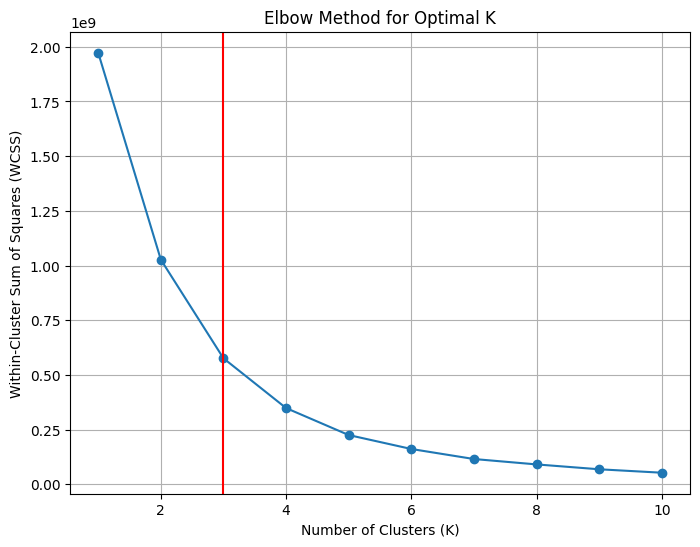

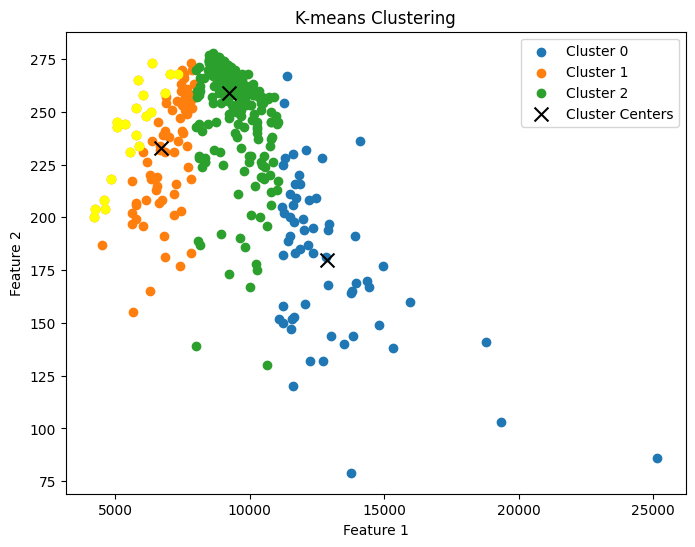

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df_agg_copy = df_agg_total.drop(['Rank'], axis = 1)

k_values = range(1, 11)
wcss = []
data = df_agg_copy[['CURRENT_LAP_TIME_MS', 'SPEED_KPH']].values

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-')
plt.axvline(x=3, color='red')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import math

data = df_agg_copy[['CURRENT_LAP_TIME_MS', 'SPEED_KPH']].values

k = 3

kmeans = KMeans(n_clusters=k)
kmeans.fit(df_agg_copy)

cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(df_agg_copy.loc[cluster_labels == i, 'CURRENT_LAP_TIME_MS'], df_agg_copy.loc[cluster_labels == i, 'SPEED_KPH'], label=f'Cluster {i}')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='x', s=100, label='Cluster Centers')

plt.scatter(df_agg_copy['CURRENT_LAP_TIME_MS'].values[:20],df_agg_copy['SPEED_KPH'].values[:20], color = "yellow")

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering')
plt.legend()
plt.show()

cluster_df = df_agg_copy[cluster_labels == 1]
cluster_df

ls_best = list(cluster_df.index)
best_df = df[df['agg'].isin(ls_best)]

In [13]:
cluster_df

,CURRENT_LAP_TIME_MS,SPEED_KPH
agg,,
9.443149153309372e+18_3,5055,245.0
1.4054303838250777e+19_4,5864,265.0
9.363995516070097e+18_2,5072,243.0
4.486621736790789e+18_6,6356,273.0
1.454581239023412e+19_2,5355,244.0
...,...,...
4.966808428094383e+18_3,5656,155.0
1.4116518083675933e+19_1,6841,181.0
3.2340270931386097e+18_2,6281,165.0


In [14]:
grouped = df.groupby(["agg"])
result = grouped["SPEED_KPH"].last()

last_time = pd.DataFrame(result)
last_time

grouped = df.groupby(["agg"])
result = grouped["CURRENT_LAP_TIME_MS"].last() - grouped["CURRENT_LAP_TIME_MS"].first()

time_sector0 = pd.DataFrame(result)
time_sector0

,CURRENT_LAP_TIME_MS
agg,
1.00346768666644e+19_1,9292
1.00346768666644e+19_2,9309
1.0045550089308109e+19_1,6890
1.0045550089308109e+19_2,5764
1.0045550089308109e+19_3,8175
...,...
9.93719767677717e+18_2,8759
9.93719767677717e+18_3,8693
9.943356580072892e+18_1,8674


In [15]:
grouped = df.groupby(["agg"])
result = grouped["SPEED_KPH"].last()

counts = pd.DataFrame(result)
counts

,SPEED_KPH
agg,
1.00346768666644e+19_1,264.0
1.00346768666644e+19_2,264.0
1.0045550089308109e+19_1,257.0
1.0045550089308109e+19_2,206.0
1.0045550089308109e+19_3,262.0
...,...
9.93719767677717e+18_2,271.0
9.93719767677717e+18_3,271.0
9.943356580072892e+18_1,274.0


In [16]:
value_counts = pd.value_counts(sorted(counts["SPEED_KPH"]))
value_counts

273.0    29
272.0    26
270.0    24
274.0    24
268.0    21
         ..
182.0     1
178.0     1
175.0     1
173.0     1
278.0     1
Length: 119, dtype: int64

In [17]:
df_agg_total = pd.concat([time_sector0, last_time], axis = 1)
df_agg_total

,CURRENT_LAP_TIME_MS,SPEED_KPH
agg,,
1.00346768666644e+19_1,9292,264.0
1.00346768666644e+19_2,9309,264.0
1.0045550089308109e+19_1,6890,257.0
1.0045550089308109e+19_2,5764,206.0
1.0045550089308109e+19_3,8175,262.0
...,...,...
9.93719767677717e+18_2,8759,271.0
9.93719767677717e+18_3,8693,271.0
9.943356580072892e+18_1,8674,274.0


In [18]:
# Adding new columns
df_agg_total = df_agg_total.assign(
    BEFORE_ENTRY_BRAKE_X = 0,
    BEFORE_ENTRY_BRAKE_Y = 0,
    BEFORE_ENTRY_BRAKE_GEAR = 0,
    BEFORE_ENTRY_BRAKE_STEERING = 0,
    BEFORE_ENTRY_BRAKE_SPEED = 0,
    BEFORE_ENTRY_BRAKE_RPM = 0,

    WITHIN_BRAKE_X = 0,
    WITHIN_BRAKE_Y = 0,
    WTHIN_BRAKE_GEAR = 0,
    WITHIN_BRAKE_STEERING = 0,
    WITHIN_BRAKE_SPEED = 0,
    WITHIN_BRAKE_RPM = 0,

    WITHIN_THROTTLE_X = 0,
    WITHIN_THROTTLE_Y = 0,
    WITHIN_THROTTLE_GEAR = 0,
    WITHIN_THROTTLE_STEERING = 0,
    WITHIN_THROTTLE_SPEED = 0,
    WITHIN_THROTTLE_RPM = 0,
)

Text(0.5, 1.0, 'Brake')

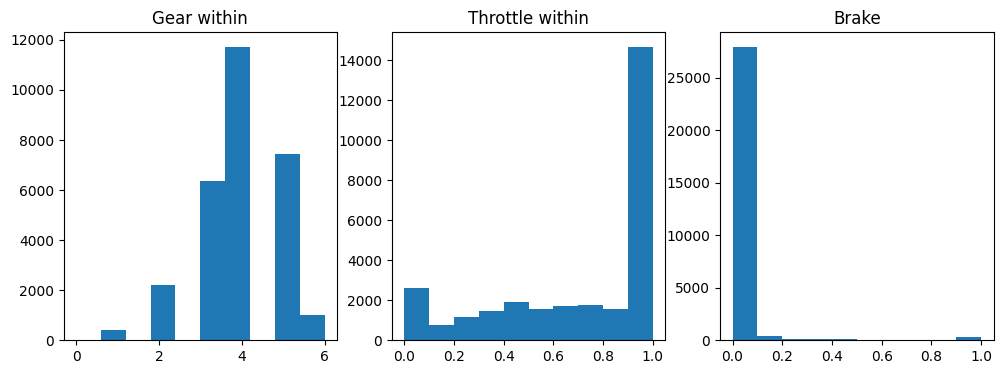

In [19]:
# Within BRAKE
condition = (350 < df["WORLDPOSX"]) & (df["WORLDPOSX"] < 400) & (0 < df["WORLDPOSY"]) & (df["WORLDPOSY"] < 200)
segmented_df = df[condition]

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot the first subplot
axs[0].hist(segmented_df["GEAR"])
axs[0].set_title('Gear within')

# Plot the second subplot
axs[1].hist(segmented_df["THROTTLE"])
axs[1].set_title('Throttle within')

# Plot the third subplot
axs[2].hist(segmented_df["BRAKE"])
axs[2].set_title('Brake')



In [20]:
# For each agg, we find the point of brake, the point of throttle etc

for i, elem in enumerate(df_agg_total.index):
    df_temp = df[df["agg"] == elem]

    counter_before = 0
    counter_within_brake = 0
    counter_within_throttle = 0

    for index, row in df_temp.iterrows():
        # BEFORE ENTRY
        if (200 < row["WORLDPOSX"] < 350) & (200 < row["WORLDPOSY"] < 400) and (counter_before == 0) and (row["BRAKE"] > 0.5):
            df_agg_total.loc[elem, 'BEFORE_ENTRY_BRAKE_X'] = row["WORLDPOSX"]
            df_agg_total.loc[elem, 'BEFORE_ENTRY_BRAKE_Y'] = row["WORLDPOSY"]
            df_agg_total.loc[elem, 'BEFORE_ENTRY_BRAKE_GEAR'] = row["GEAR"]
            df_agg_total.loc[elem, 'BEFORE_ENTRY_BRAKE_STEERING'] = row["STEERING"]
            df_agg_total.loc[elem, 'BEFORE_ENTRY_BRAKE_SPEED'] = row["SPEED_KPH"]
            df_agg_total.loc[elem, 'BEFORE_ENTRY_BRAKE_RPM'] = row["ENGINE_RPM"]
            counter_before = 1


        # WITHIN BRAKE. We expect very little braking so we find when there is a little brake.
        if (350 < row["WORLDPOSX"] < 400) & (100 < row["WORLDPOSY"] < 250) and (counter_within_brake == 0) and row["THROTTLE"] > 0:
            df_agg_total.loc[elem, 'WITHIN_BRAKE_X'] = row["WORLDPOSX"]
            df_agg_total.loc[elem, 'WITHIN_BRAKE_Y'] = row["WORLDPOSY"]
            df_agg_total.loc[elem, 'WITHIN_BRAKE_GEAR'] = row["GEAR"]
            df_agg_total.loc[elem, 'WITHIN_BRAKE_STEERING'] = row["STEERING"]
            df_agg_total.loc[elem, 'WITHIN_BRAKE_SPEED'] = row["SPEED_KPH"]
            df_agg_total.loc[elem, 'WITHIN_BRAKE_RPM'] = row["ENGINE_RPM"]
            counter_within_brake = 1


        # WITHIN THROTTLE
        if (350 < row["WORLDPOSX"] < 500) & (-100 < row["WORLDPOSY"] < 100) and (counter_within_throttle == 0) and row["THROTTLE"] > 0.5:
            df_agg_total.loc[elem, 'WITHIN_THROTTLE_X'] = row["WORLDPOSX"]
            df_agg_total.loc[elem, 'WITHIN_THROTTLE_Y'] = row["WORLDPOSY"]
            df_agg_total.loc[elem, 'WITHIN_THROTTLE_GEAR'] = row["GEAR"]
            df_agg_total.loc[elem, 'WITHIN_THROTTLE_STEERING'] = row["STEERING"]
            df_agg_total.loc[elem, 'WITHIN_THROTTLE_SPEED'] = row["SPEED_KPH"]
            df_agg_total.loc[elem, 'WITHIN_THROTTLE_RPM'] = row["ENGINE_RPM"]
            counter_within_throttle = 1

In [21]:
df_agg_total

,CURRENT_LAP_TIME_MS,SPEED_KPH,BEFORE_ENTRY_BRAKE_X,BEFORE_ENTRY_BRAKE_Y,BEFORE_ENTRY_BRAKE_GEAR,BEFORE_ENTRY_BRAKE_STEERING,BEFORE_ENTRY_BRAKE_SPEED,BEFORE_ENTRY_BRAKE_RPM,WITHIN_BRAKE_X,WITHIN_BRAKE_Y,WTHIN_BRAKE_GEAR,WITHIN_BRAKE_STEERING,WITHIN_BRAKE_SPEED,WITHIN_BRAKE_RPM,WITHIN_THROTTLE_X,WITHIN_THROTTLE_Y,WITHIN_THROTTLE_GEAR,WITHIN_THROTTLE_STEERING,WITHIN_THROTTLE_SPEED,WITHIN_THROTTLE_RPM,WITHIN_BRAKE_GEAR
agg,,,,,,,,,,,,,,,,,,,,,
1.00346768666644e+19_1,9292,264.0,317.043945,270.647095,8,0.004349,314,10905,376.925842,194.277664,0,0.393271,141,8375,368.082977,98.278923,4,-0.140398,172,10706,4.0
1.00346768666644e+19_2,9309,264.0,310.493561,277.280243,8,0.006088,322,11187,378.177704,178.318848,0,0.531334,126,9174,367.813263,98.085762,4,-0.099107,164,10314,3.0
1.0045550089308109e+19_1,6890,257.0,326.941986,261.094025,8,-0.008652,278,9431,370.639648,141.009048,0,-0.199542,165,10425,369.129425,94.604286,4,-0.121080,188,11872,4.0
1.0045550089308109e+19_2,5764,206.0,0.000000,0.000000,0,0.000000,0,0,366.887451,105.027191,0,-0.155138,192,11994,367.765686,98.796402,5,-0.141405,195,10702,4.0
1.0045550089308109e+19_3,8175,262.0,311.309509,276.671387,8,-0.006088,293,9950,369.462494,135.245743,0,-0.405356,174,10921,378.584595,63.873695,5,-0.179675,208,11371,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.93719767677717e+18_2,8759,271.0,320.462250,267.711731,8,0.002518,290,9877,352.396942,236.498169,0,0.112932,231,10356,367.964752,98.145020,5,-0.156329,206,11225,6.0
9.93719767677717e+18_3,8693,271.0,327.554535,261.473999,8,0.009018,286,9729,352.182373,236.721283,0,0.093980,232,10379,368.967682,99.096771,5,-0.174456,204,11190,6.0
9.943356580072892e+18_1,8674,274.0,314.986145,273.048645,8,0.003891,309,10545,363.801086,222.501602,0,0.254475,175,9055,368.035370,99.284180,5,-0.153491,211,11483,5.0


In [23]:
df_agg_total = df_agg_total.dropna(axis=1)
df_agg_total

,CURRENT_LAP_TIME_MS,SPEED_KPH,BEFORE_ENTRY_BRAKE_X,BEFORE_ENTRY_BRAKE_Y,BEFORE_ENTRY_BRAKE_GEAR,BEFORE_ENTRY_BRAKE_STEERING,BEFORE_ENTRY_BRAKE_SPEED,BEFORE_ENTRY_BRAKE_RPM,WITHIN_BRAKE_X,WITHIN_BRAKE_Y,WTHIN_BRAKE_GEAR,WITHIN_BRAKE_STEERING,WITHIN_BRAKE_SPEED,WITHIN_BRAKE_RPM,WITHIN_THROTTLE_X,WITHIN_THROTTLE_Y,WITHIN_THROTTLE_GEAR,WITHIN_THROTTLE_STEERING,WITHIN_THROTTLE_SPEED,WITHIN_THROTTLE_RPM
agg,,,,,,,,,,,,,,,,,,,,
1.00346768666644e+19_1,9292,264.0,317.043945,270.647095,8,0.004349,314,10905,376.925842,194.277664,0,0.393271,141,8375,368.082977,98.278923,4,-0.140398,172,10706
1.00346768666644e+19_2,9309,264.0,310.493561,277.280243,8,0.006088,322,11187,378.177704,178.318848,0,0.531334,126,9174,367.813263,98.085762,4,-0.099107,164,10314
1.0045550089308109e+19_1,6890,257.0,326.941986,261.094025,8,-0.008652,278,9431,370.639648,141.009048,0,-0.199542,165,10425,369.129425,94.604286,4,-0.121080,188,11872
1.0045550089308109e+19_2,5764,206.0,0.000000,0.000000,0,0.000000,0,0,366.887451,105.027191,0,-0.155138,192,11994,367.765686,98.796402,5,-0.141405,195,10702
1.0045550089308109e+19_3,8175,262.0,311.309509,276.671387,8,-0.006088,293,9950,369.462494,135.245743,0,-0.405356,174,10921,378.584595,63.873695,5,-0.179675,208,11371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.93719767677717e+18_2,8759,271.0,320.462250,267.711731,8,0.002518,290,9877,352.396942,236.498169,0,0.112932,231,10356,367.964752,98.145020,5,-0.156329,206,11225
9.93719767677717e+18_3,8693,271.0,327.554535,261.473999,8,0.009018,286,9729,352.182373,236.721283,0,0.093980,232,10379,368.967682,99.096771,5,-0.174456,204,11190
9.943356580072892e+18_1,8674,274.0,314.986145,273.048645,8,0.003891,309,10545,363.801086,222.501602,0,0.254475,175,9055,368.035370,99.284180,5,-0.153491,211,11483


In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
# Create a new DataFrame to store the rows that satisfy the condition
final_df = pd.DataFrame(columns=df_agg_total.columns)

# If X, Y = 0 for each of the 3 we can
for index, row in df_agg_total.iterrows():
  if (row["BEFORE_ENTRY_BRAKE_X"] == row["BEFORE_ENTRY_BRAKE_Y"] == row["WITHIN_BRAKE_X"] == row["WITHIN_BRAKE_Y"] == row["WITHIN_THROTTLE_X"] == row["WITHIN_THROTTLE_Y"] == 0):
    continue
  else:
    final_df = final_df.append(row)


In [26]:
final_df

,CURRENT_LAP_TIME_MS,SPEED_KPH,BEFORE_ENTRY_BRAKE_X,BEFORE_ENTRY_BRAKE_Y,BEFORE_ENTRY_BRAKE_GEAR,BEFORE_ENTRY_BRAKE_STEERING,BEFORE_ENTRY_BRAKE_SPEED,BEFORE_ENTRY_BRAKE_RPM,WITHIN_BRAKE_X,WITHIN_BRAKE_Y,WTHIN_BRAKE_GEAR,WITHIN_BRAKE_STEERING,WITHIN_BRAKE_SPEED,WITHIN_BRAKE_RPM,WITHIN_THROTTLE_X,WITHIN_THROTTLE_Y,WITHIN_THROTTLE_GEAR,WITHIN_THROTTLE_STEERING,WITHIN_THROTTLE_SPEED,WITHIN_THROTTLE_RPM
1.00346768666644e+19_1,9292.0,264.0,317.043945,270.647095,8.0,0.004349,314.0,10905.0,376.925842,194.277664,0.0,0.393271,141.0,8375.0,368.082977,98.278923,4.0,-0.140398,172.0,10706.0
1.00346768666644e+19_2,9309.0,264.0,310.493561,277.280243,8.0,0.006088,322.0,11187.0,378.177704,178.318848,0.0,0.531334,126.0,9174.0,367.813263,98.085762,4.0,-0.099107,164.0,10314.0
1.0045550089308109e+19_1,6890.0,257.0,326.941986,261.094025,8.0,-0.008652,278.0,9431.0,370.639648,141.009048,0.0,-0.199542,165.0,10425.0,369.129425,94.604286,4.0,-0.121080,188.0,11872.0
1.0045550089308109e+19_2,5764.0,206.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,366.887451,105.027191,0.0,-0.155138,192.0,11994.0,367.765686,98.796402,5.0,-0.141405,195.0,10702.0
1.0045550089308109e+19_3,8175.0,262.0,311.309509,276.671387,8.0,-0.006088,293.0,9950.0,369.462494,135.245743,0.0,-0.405356,174.0,10921.0,378.584595,63.873695,5.0,-0.179675,208.0,11371.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.93719767677717e+18_2,8759.0,271.0,320.462250,267.711731,8.0,0.002518,290.0,9877.0,352.396942,236.498169,0.0,0.112932,231.0,10356.0,367.964752,98.145020,5.0,-0.156329,206.0,11225.0
9.93719767677717e+18_3,8693.0,271.0,327.554535,261.473999,8.0,0.009018,286.0,9729.0,352.182373,236.721283,0.0,0.093980,232.0,10379.0,368.967682,99.096771,5.0,-0.174456,204.0,11190.0
9.943356580072892e+18_1,8674.0,274.0,314.986145,273.048645,8.0,0.003891,309.0,10545.0,363.801086,222.501602,0.0,0.254475,175.0,9055.0,368.035370,99.284180,5.0,-0.153491,211.0,11483.0
9.943356580072892e+18_2,8640.0,273.0,315.281097,272.392517,8.0,0.001144,305.0,10413.0,351.086670,237.644592,0.0,0.091966,231.0,10316.0,365.998932,97.524109,5.0,-0.219226,209.0,11471.0


In [27]:
final_df["noise"] = np.random.normal(0, 1, len(final_df))
final_df

,CURRENT_LAP_TIME_MS,SPEED_KPH,BEFORE_ENTRY_BRAKE_X,BEFORE_ENTRY_BRAKE_Y,BEFORE_ENTRY_BRAKE_GEAR,BEFORE_ENTRY_BRAKE_STEERING,BEFORE_ENTRY_BRAKE_SPEED,BEFORE_ENTRY_BRAKE_RPM,WITHIN_BRAKE_X,WITHIN_BRAKE_Y,WTHIN_BRAKE_GEAR,WITHIN_BRAKE_STEERING,WITHIN_BRAKE_SPEED,WITHIN_BRAKE_RPM,WITHIN_THROTTLE_X,WITHIN_THROTTLE_Y,WITHIN_THROTTLE_GEAR,WITHIN_THROTTLE_STEERING,WITHIN_THROTTLE_SPEED,WITHIN_THROTTLE_RPM,noise
1.00346768666644e+19_1,9292.0,264.0,317.043945,270.647095,8.0,0.004349,314.0,10905.0,376.925842,194.277664,0.0,0.393271,141.0,8375.0,368.082977,98.278923,4.0,-0.140398,172.0,10706.0,-0.815905
1.00346768666644e+19_2,9309.0,264.0,310.493561,277.280243,8.0,0.006088,322.0,11187.0,378.177704,178.318848,0.0,0.531334,126.0,9174.0,367.813263,98.085762,4.0,-0.099107,164.0,10314.0,-0.422402
1.0045550089308109e+19_1,6890.0,257.0,326.941986,261.094025,8.0,-0.008652,278.0,9431.0,370.639648,141.009048,0.0,-0.199542,165.0,10425.0,369.129425,94.604286,4.0,-0.121080,188.0,11872.0,-0.358035
1.0045550089308109e+19_2,5764.0,206.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,366.887451,105.027191,0.0,-0.155138,192.0,11994.0,367.765686,98.796402,5.0,-0.141405,195.0,10702.0,0.426491
1.0045550089308109e+19_3,8175.0,262.0,311.309509,276.671387,8.0,-0.006088,293.0,9950.0,369.462494,135.245743,0.0,-0.405356,174.0,10921.0,378.584595,63.873695,5.0,-0.179675,208.0,11371.0,0.731091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.93719767677717e+18_2,8759.0,271.0,320.462250,267.711731,8.0,0.002518,290.0,9877.0,352.396942,236.498169,0.0,0.112932,231.0,10356.0,367.964752,98.145020,5.0,-0.156329,206.0,11225.0,0.702995
9.93719767677717e+18_3,8693.0,271.0,327.554535,261.473999,8.0,0.009018,286.0,9729.0,352.182373,236.721283,0.0,0.093980,232.0,10379.0,368.967682,99.096771,5.0,-0.174456,204.0,11190.0,-0.665967
9.943356580072892e+18_1,8674.0,274.0,314.986145,273.048645,8.0,0.003891,309.0,10545.0,363.801086,222.501602,0.0,0.254475,175.0,9055.0,368.035370,99.284180,5.0,-0.153491,211.0,11483.0,-0.054247
9.943356580072892e+18_2,8640.0,273.0,315.281097,272.392517,8.0,0.001144,305.0,10413.0,351.086670,237.644592,0.0,0.091966,231.0,10316.0,365.998932,97.524109,5.0,-0.219226,209.0,11471.0,0.931948


In [28]:
## Random Forest

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = final_df.drop('SPEED_KPH', axis=1)
y = final_df['SPEED_KPH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared (R2): {r2}')


Mean Squared Error: 307.51914085365854
R-squared (R2): 0.739222961714113


In [30]:
## LightGBM

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = final_df.drop('SPEED_KPH', axis=1)
y = final_df['SPEED_KPH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared (R2): {r2}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 381, number of used features: 19
[LightGBM] [Info] Start training from score 246.104987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [31]:
## XGBoost

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = final_df.drop('SPEED_KPH', axis=1)
y = final_df['SPEED_KPH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error: 345.0095529656434
R-squared (R2): 0.707430993879066


In [32]:
## Linear Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

X = final_df.drop('SPEED_KPH', axis=1)
y = final_df['SPEED_KPH']

# Standardize the features (X) for normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Linear Regression - Mean Squared Error: {mse}')
print(f'Linear Regression - R-squared (R2): {r2}')

Linear Regression - Mean Squared Error: 329.86272832490596
Linear Regression - R-squared (R2): 0.720275540915333


In [33]:
## Lasso Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

X = final_df.drop('SPEED_KPH', axis=1)
y = final_df['SPEED_KPH']

# Standardize the features (X) for normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

y_pred = lasso_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Lasso Regression - Mean Squared Error: {mse}')
print(f'Lasso Regression - R-squared (R2): {r2}')

Lasso Regression - Mean Squared Error: 308.0233949393365
Lasso Regression - R-squared (R2): 0.7387953529264399


In [34]:
## Ridge Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

X = final_df.drop('SPEED_KPH', axis=1)
y = final_df['SPEED_KPH']

# Standardize the features (X) for normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Ridge Regression - Mean Squared Error: {mse}')
print(f'Ridge Regression - R-squared (R2): {r2}')


Ridge Regression - Mean Squared Error: 340.14263482434774
Ridge Regression - R-squared (R2): 0.7115581532322814


In [35]:
## KNN Regression

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

X = final_df.drop('SPEED_KPH', axis=1)
y = final_df['SPEED_KPH']

# Standardize the features (X) for normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Choose the number of neighbors (k) for KNN
k = 5

knn_model = KNeighborsRegressor(n_neighbors=k)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'KNN Regression (k={k}) - Mean Squared Error: {mse}')
print(f'KNN Regression (k={k}) - R-squared (R2): {r2}')


KNN Regression (k=5) - Mean Squared Error: 344.3458536585366
KNN Regression (k=5) - R-squared (R2): 0.7079938126328491


In [36]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_model, X_test, y_test, n_repeats=100, random_state=42
)

# Simulated Annealing

In [37]:
## Simulated Annealing

final_df_copy = final_df.drop(["CURRENT_LAP_TIME_MS", "noise"], axis = 1)

X = final_df_copy.drop('SPEED_KPH', axis=1)
y = final_df_copy['SPEED_KPH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1570
[LightGBM] [Info] Number of data points in the train set: 381, number of used features: 17
[LightGBM] [Info] Start training from score 246.104987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMRegressor()

In [39]:
print(len(X_train.columns))

18


In [40]:
from scipy.optimize import minimize

# Define the objective function that we want to minimize (or maximize)
# In this case, let's say we want to find the input that minimizes the predicted value
def objective_function(inputs):
    # The model expects a 2D array for the inputs
    inputs_2d = np.array(inputs).reshape(1, -1)
    return -lgb_model.predict(inputs_2d)


bounds = [(200, 350), (200, 400), (0, 8), (-1, 1), (min(X_train["BEFORE_ENTRY_BRAKE_SPEED"]), max(X_train["BEFORE_ENTRY_BRAKE_SPEED"])), (min(X_train["BEFORE_ENTRY_BRAKE_RPM"]), max(X_train["BEFORE_ENTRY_BRAKE_RPM"])),
 (350, 400), (100, 250), (0, 8), (-1, 1), (min(X_train["WITHIN_BRAKE_SPEED"]), max(X_train["WITHIN_BRAKE_SPEED"])), (min(X_train["WITHIN_BRAKE_RPM"]), max(X_train["WITHIN_BRAKE_RPM"])),
  (350, 500), (-100, 100), (0, 8), (-1, 1), (min(X_train["WITHIN_THROTTLE_SPEED"]), max(X_train["WITHIN_THROTTLE_SPEED"])),(min(X_train["WITHIN_THROTTLE_RPM"]), max(X_train["WITHIN_THROTTLE_RPM"]))] #track ratio added


# The 'L-BFGS-B' method is a quasi-Newton method that can handle bound constraints
result = minimize(objective_function, x0=X_train.iloc[5], bounds=bounds, method='L-BFGS-B')

# The optimal inputs that minimize the prediction
optimal_inputs = result.x
optimal_prediction = objective_function(optimal_inputs)

optimal_inputs, optimal_prediction

(array([2.00000000e+02, 2.00000000e+02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.55692017e+02, 2.34196274e+02,
        0.00000000e+00, 1.29411772e-01, 2.24000000e+02, 1.01420000e+04,
        4.28768707e+02, 7.84140921e+00, 4.00000000e+00, 1.57427326e-01,
        1.83000000e+02, 1.17510000e+04]),
 array([-185.66713046]))

In [41]:
from scipy.optimize import differential_evolution

result = differential_evolution(objective_function, bounds)

optimal_inputs = result.x

In [42]:
d = {'columns' : list(X_train.columns), 'values': optimal_inputs}

d_df = pd.DataFrame(d)

In [43]:
d_df

,columns,values
0,BEFORE_ENTRY_BRAKE_X,338.778357
1,BEFORE_ENTRY_BRAKE_Y,357.016244
2,BEFORE_ENTRY_BRAKE_GEAR,1.133769
3,BEFORE_ENTRY_BRAKE_STEERING,-0.065654
4,BEFORE_ENTRY_BRAKE_SPEED,331.776719
5,BEFORE_ENTRY_BRAKE_RPM,2735.014325
6,WITHIN_BRAKE_X,368.196768
7,WITHIN_BRAKE_Y,127.067942
8,WTHIN_BRAKE_GEAR,6.670745
9,WITHIN_BRAKE_STEERING,0.160105


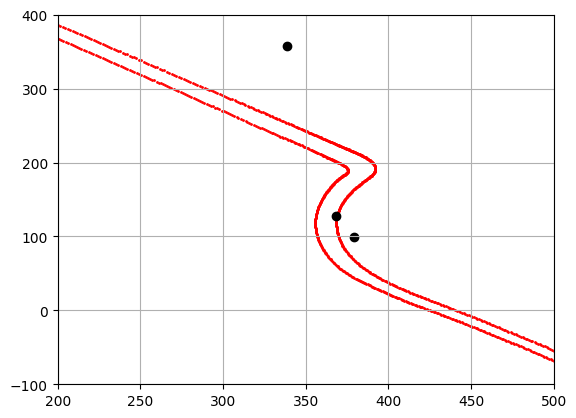

In [44]:
plt.scatter(left["WORLDPOSX"], left["WORLDPOSY"],s=1,c='red')
plt.scatter(right["WORLDPOSX"], right["WORLDPOSY"], s=1,c='red')
plt.scatter(d_df["values"][0], d_df["values"][1], c='black')
plt.scatter(d_df["values"][6],d_df["values"][7], c='black')
plt.scatter(d_df["values"][12],d_df["values"][13], c='black')
plt.xlim(200, 500)
plt.ylim(-100, 400)
plt.grid()
plt.show()